In [1]:
import torch
from torchdrug import data, datasets
import pickle

# dataset = datasets.ZINC250k("~/molecule-datasets/", kekulize=True,
#                             atom_feature="symbol")
# with open("torchdrug_data/zinc250k.pkl", "wb") as fout:
#     pickle.dump(dataset, fout)
    
# with open("torchdrug_data/zinc250k.pkl", "rb") as fin:
#     dataset = pickle.load(fin)
    
dataset = datasets.ZINC250k("~/molecule-datasets/", kekulize=True, atom_feature="symbol")

lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

Loading /data/yulai/molecule-datasets/250k_rndm_zinc_drugs_clean_3.csv:  50%|█████     | 249456/498911 [00:02<00:02, 103373.72it/s]
Constructing molecules from SMILES: 100%|██████████| 249455/249455 [05:49<00:00, 713.65it/s]


In [2]:
print(dataset.node_feature_dim)
print(dataset.edge_feature_dim)
print(dataset.tasks)

18
18
['logP', 'qed']


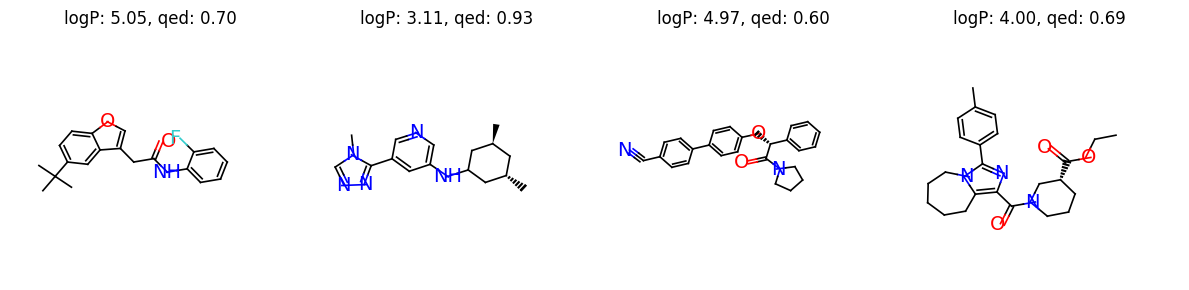

In [3]:
%matplotlib inline
graphs = []
labels = []
for i in range(4):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %.2f" % (k, v) for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

In [4]:
from torchdrug import core, models, tasks, utils

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
task = tasks.PropertyPrediction(model, task=['qed'], metric=("mae", "r2"))

In [8]:
num_epoch = 50
lr = 1e-5

optimizer = torch.optim.Adam(task.parameters(), lr=lr)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[0], batch_size=1024, logger="wandb")
solver.train(num_epoch=num_epoch)

print("Evaluating on validation set......")
solver.evaluate("valid")

print("Evaluating on test set......")
solver.evaluate("test")
solver.save("torchdrug_data/zinc/GIN_epoch=%d_lr=%s.pkl"%(num_epoch,lr))

21:43:47   Preprocess training set


/data/yulai/anaconda3/envs/torchdrug/lib/python3.9/site-packages/torchdrug/core/logger.py:105: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` or `WandbLogger.finish()` before instantiating `WandbLogger`.
  warnings.warn(


21:43:48   {'batch_size': 1024,
 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'wandb',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'capturable': False,
               'class': 'optim.Adam',
               'differentiable': False,
               'eps': 1e-08,
               'foreach': None,
               'fused': None,
               'lr': 1e-05,
               'maximize': False,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'mse',
          'graph_construction_model': None,
          'metric': ('mae', 'r2'),
          'mlp_batch_norm': False,
          'mlp_dropout': 0,
          'model': {'activation': 'relu',
                    'batch_norm': True,
                    'class': 'models.GIN',
                    'concat_hidden': True,
                    'edge_input_dim': None,
                    

wandb: WARNING Serializing object of type list that is 1624056 bytes
wandb: WARNING Serializing object of type list that is 219064 bytes
wandb: WARNING Serializing object of type list that is 219064 bytes


21:43:48   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:43:48   Epoch 0 begin
21:43:49   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:43:49   mean squared error: 852.067
21:43:58   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:43:58   mean squared error: 352.537
21:44:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:44:07   Epoch 0 end
21:44:07   duration: 19.41 secs
21:44:07   speed: 10.05 batch / sec
21:44:07   ETA: 15.85 mins
21:44:07   max GPU memory: 15396.1 MiB
21:44:07   ------------------------------
21:44:07   average mean squared error: 406.764
21:44:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:44:07   Epoch 1 begin
21:44:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:44:07   mean squared error: 153.336
21:44:17   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:44:17   mean squared error: 59.0723
21:44:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21:44:25   Epoch 1 end
21:44:25   duration: 18.25 secs
21:44:25   speed: 10.69 batch / sec
21:44:25   ETA: 15.06 mins
21:44:25   max GPU memory: 11881.7 MiB
21:44:25   ------------------------------
21:44:25   av

: 

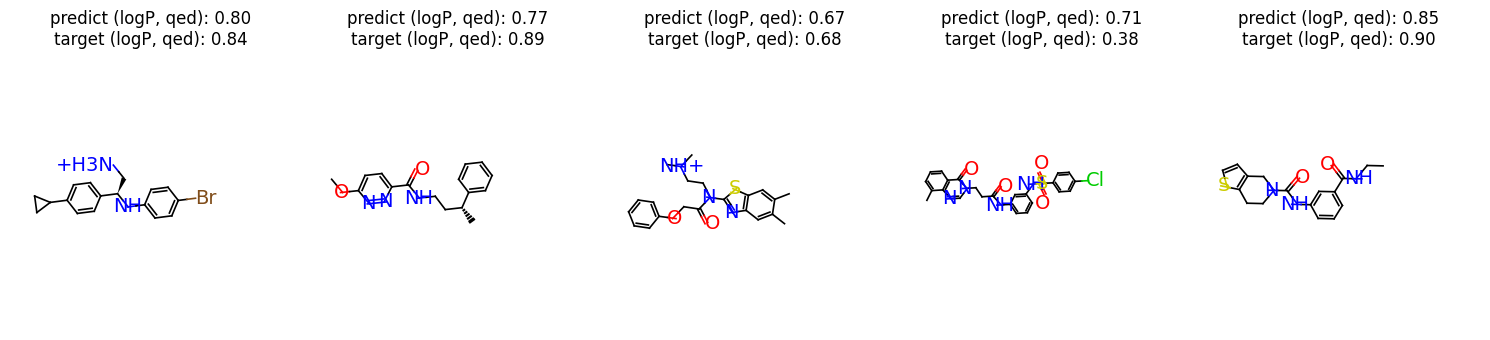

In [6]:
%matplotlib inline
from torch.nn import functional as F

samples = []
categories = set()
for sample in test_set[:5]:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    if category not in categories:
        categories.add(category)
        samples.append(sample)
samples = data.graph_collate(samples)
samples = utils.cuda(samples)

preds = task.predict(samples)
targets = task.target(samples)

titles = []
for pred, target in zip(preds, targets):
    pred = ", ".join(["%.2f" % p for p in pred])
    target = ", ".join(["%.2f" % t for t in target])
    titles.append("predict (logP, qed): %s\ntarget (logP, qed): %s" % (pred, target))
graph = samples["graph"]
graph.visualize(titles, figure_size=(3, 3.5), num_row=1)

(array([4.000e+00, 1.000e+00, 6.000e+00, 7.000e+00, 6.000e+00, 1.300e+01,
        1.800e+01, 1.900e+01, 3.900e+01, 3.500e+01, 4.400e+01, 5.400e+01,
        9.400e+01, 1.110e+02, 1.210e+02, 1.200e+02, 1.530e+02, 1.540e+02,
        1.850e+02, 2.080e+02, 2.810e+02, 2.870e+02, 2.990e+02, 3.120e+02,
        3.240e+02, 3.670e+02, 4.160e+02, 5.050e+02, 5.250e+02, 6.350e+02,
        6.730e+02, 6.970e+02, 7.450e+02, 7.850e+02, 8.410e+02, 8.900e+02,
        9.760e+02, 1.089e+03, 1.143e+03, 1.311e+03, 1.358e+03, 1.315e+03,
        1.381e+03, 1.525e+03, 1.300e+03, 1.144e+03, 9.060e+02, 7.610e+02,
        4.960e+02, 1.960e+02]),
 array([0.13987732, 0.15602931, 0.17218131, 0.18833329, 0.20448528,
        0.22063728, 0.23678927, 0.25294125, 0.26909325, 0.28524524,
        0.30139723, 0.31754923, 0.33370122, 0.34985319, 0.36600518,
        0.38215718, 0.39830917, 0.41446117, 0.43061316, 0.44676515,
        0.46291715, 0.47906911, 0.49522111, 0.5113731 , 0.52752513,
        0.54367709, 0.55982906, 0.57

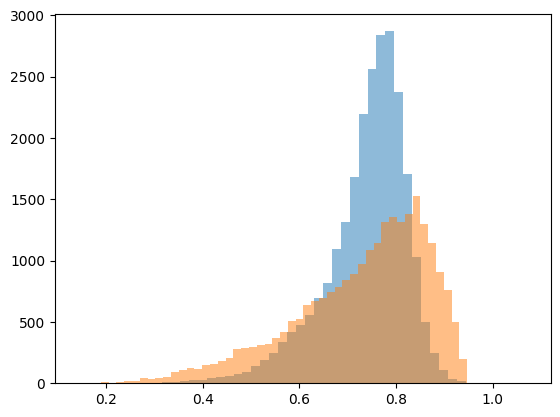

In [7]:
import matplotlib.pyplot as plt

samples = []
categories = set()
for sample in test_set:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    if category not in categories:
        categories.add(category)
        samples.append(sample)
samples = data.graph_collate(samples)
samples = utils.cuda(samples)

preds = task.predict(samples)
targets = task.target(samples)

plt.hist(preds[:, 0].detach().cpu().numpy(), bins=50, alpha=0.5, label="predict")
plt.hist(targets[:, 0].detach().cpu().numpy(), bins=50, alpha=0.5, label="target")